HW

In [22]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
import math

data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', error_bad_lines=False, low_memory=False) # raw dataset

data.head()

# nutrition_grade_fr

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Exploration préliminaire

In [23]:
print(f'Le dataframe brut comporte {data.shape[0]} éléments et {data.shape[1]} colonnes.')

Le dataframe brut comporte 320772 éléments et 162 colonnes.


In [24]:
nutriments = ["energy_100g","fat_100g","carbohydrates_100g", "fiber_100g","proteins_100g","sodium_100g"]
print(data['categories'].describe())
for nutr in nutriments:
    print('\n')
    print(data[nutr].describe())

count                                          84410
unique                                         36982
top       Snacks sucrés,Biscuits et gâteaux,Biscuits
freq                                             301
Name: categories, dtype: object


count    2.611130e+05
mean     1.141915e+03
std      6.447154e+03
min      0.000000e+00
25%      3.770000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64


count    243891.000000
mean         12.730379
std          17.578747
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max         714.290000
Name: fat_100g, dtype: float64


count    243588.000000
mean         32.073981
std          29.731719
min           0.000000
25%           6.000000
50%          20.600000
75%          58.330000
max        2916.670000
Name: carbohydrates_100g, dtype: float64


count    200886.000000
mean          2.862111
std          12.867578
min          -6.700000
25%   

### Nettoyage des données

In [25]:
for col in nutriments:
    data = data[data[col].notnull()]

maxvalue = [3766, 100, 100, 100, 100, 100]

for col, maxv in zip(nutriments, maxvalue):
    data = data[data[col].notnull()]
    # calculating thresholds for aberrant values
    stats = data[col].describe()
    q1 = stats.loc["25%"]
    q3 = stats.loc["75%"]
    default_value = q3 + 1.5 * (q3 - q1)
    # replacing aberrant & missing values in parent dataframe
    for index, row in data.iterrows():
        if row[col] > maxv:
            data.at[index, col] = default_value
    print(data[col].describe(), end='\n\n')

count    181265.000000
mean       1174.525926
std         756.530274
min           0.000000
25%         444.000000
50%        1197.000000
75%        1724.000000
max        3766.000000
Name: energy_100g, dtype: float64

count    181265.000000
mean         12.815478
std          15.646340
min           0.000000
25%           0.620000
50%           6.670000
75%          21.000000
max         100.000000
Name: fat_100g, dtype: float64

count    181265.000000
mean         34.366222
std          28.200455
min           0.000000
25%           8.000000
50%          26.060000
75%          60.000000
max         138.000000
Name: carbohydrates_100g, dtype: float64

count    181265.000000
mean          2.882830
std           4.474679
min           0.000000
25%           0.000000
50%           1.600000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

count    181265.000000
mean          7.651083
std           7.933297
min          -3.570000
25%           1.830000
50%   

In [26]:
entries = data.shape[0]
for col in data.columns: 
    missing_values = data[col].isnull().sum()
    if missing_values > entries / 2 and col != 'categories':
        data = data.drop([col],axis=1)


### Bilan

In [27]:
print(f'Elements restants après traitement: {data.shape[0]}. Colonnes: {data.shape[1]}. Doublons: {data.shape[0]-len(data["code"].unique())}')


Elements restants après traitement: 181265. Colonnes: 43. Doublons: 0


### Analyse monovariée

In [28]:
drop_cols = ["url", "creator", "created_t", "created_datetime", "last_modified_t", "last_modified_datetime",
             "brands_tags", "countries", "countries_tags", "countries_fr", "ingredients_from_palm_oil_n",
             "ingredients_that_may_be_from_palm_oil_n", "states", "states_tags", "states_fr",
             "nutrition-score-fr_100g","nutrition_grade_fr","code","additives"]
#data = data.drop(drop_cols, axis=1)

for col in data.columns:
    print(f"{col} {data[col].isnull().sum()}")
    
print(len(data.columns))

code 0
url 0
creator 0
created_t 0
created_datetime 1
last_modified_t 0
last_modified_datetime 0
product_name 2141
brands 3870
brands_tags 3871
categories 146397
countries 25
countries_tags 25
countries_fr 25
ingredients_text 5984
serving_size 17403
additives_n 5984
additives 6001
additives_tags 68656
additives_fr 68656
ingredients_from_palm_oil_n 5984
ingredients_that_may_be_from_palm_oil_n 5984
nutrition_grade_fr 4970
states 0
states_tags 0
states_fr 0
energy_100g 0
fat_100g 0
saturated-fat_100g 3802
trans-fat_100g 47460
cholesterol_100g 45715
carbohydrates_100g 0
sugars_100g 1331
fiber_100g 0
proteins_100g 0
salt_100g 0
sodium_100g 0
vitamin-a_100g 48857
vitamin-c_100g 47896
calcium_100g 46419
iron_100g 46097
nutrition-score-fr_100g 4970
nutrition-score-uk_100g 4970
43


### ACP

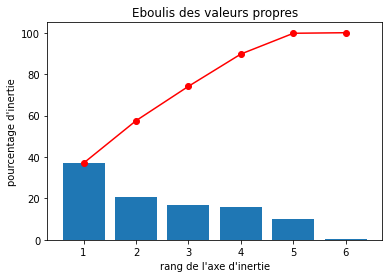

In [29]:
# choix du nombre de composantes à calculer
n_comp = len(nutriments)

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[nutriments]

# préparation des données pour l'ACP
#data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

plt.show()

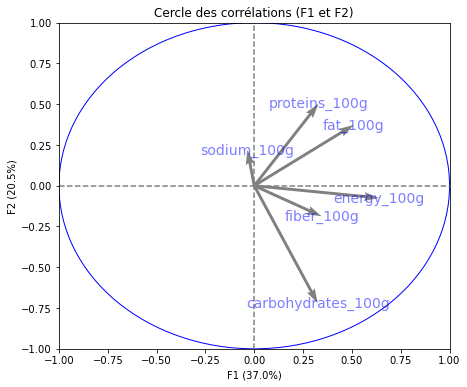

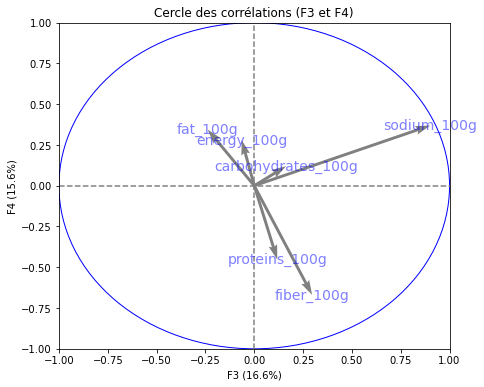

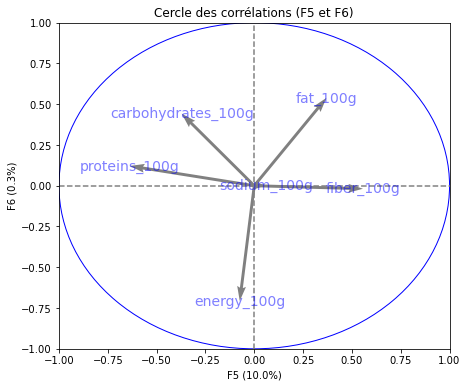

In [30]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))
plt.show()

In [31]:
# Projection des individus
#names = data.index ??
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

### ANOVA

In [32]:
print(data["brands"].value_counts())
print(len(data["brands_tags"].unique()))
print(data["brands"].str.contains("Carrefour").sum())


Meijer                     1622
Carrefour                  1455
Kroger                     1378
U                          1282
Great Value                1123
                           ... 
A&B Famous Gefilte Fish       1
Slice Mmms                    1
ProSain                       1
Sapporo Ichiban               1
Golden Grain Co.              1
Name: brands, Length: 32157, dtype: int64
28982
2204


In [36]:
# creating a new column for brands

mybrands = ["Meijer", "Carrefour", "Kroger", "U", "Great Value"]

def getfirstbrand(string):
    if isinstance(string, float):
        return string
    main_brand = string.split(',')[0]
    if main_brand not in mybrands:
        return float('NaN')
    return main_brand

data['main_brand'] = data['brands'].apply(getfirstbrand)


In [41]:
X = "main_brand" # qualitative
Y = "nutrition-score-fr_100g" # quantitative

sous_echantillon = data[data["main_brand"].notnull()]

print(sous_echantillon["nutrition-score-fr_100g"].describe())

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

count    7870.000000
mean        7.887929
std         9.051996
min       -13.000000
25%         0.000000
50%         8.000000
75%        15.000000
max        35.000000
Name: nutrition-score-fr_100g, dtype: float64


nan